# Imports & Consts

In [1]:
import cv2 as cv
from matplotlib import pyplot as plt
import numpy as np
import os, random

K = 7

# Some Util functions

In [2]:
# Util function to load image from given path, as grayscale
def load_image_as_grayscale(image_path: str) -> np.ndarray:
    return cv.imread(image_path, cv.IMREAD_GRAYSCALE)

In [3]:
# Util function to load images sets with their lables and filenames
def load_images_set(resources_path, files_to_ignore=[], leave_out=1):
    labels = []
    images = []
    file_names = []
    for subdir, dirs, files in os.walk(resources_path):
        available_files = [name for name in os.listdir(subdir) if os.path.isfile(os.path.join(subdir, name))]
        available_files = [item for item in available_files if os.path.join(subdir,item) not in files_to_ignore]
        while subdir != resources_path and len(available_files)>leave_out:
            file_name = available_files.pop()
            img = load_image_as_grayscale(os.path.join(subdir, file_name))
            if img is not None and file_name not in file_names:
                faces = viola_jones(img)
                for face in faces:
                    file_names.append(os.path.join(subdir,file_name))
                    labels.append(subdir.split('/')[-1])
                    images.append(face)
            else:
                break
    return labels, images, file_names


In [4]:
# Util function to plot images (& labels) sets, and generating a matching matrix
def plot_set_and_get_matrix(images, labels):
    width, height = images[0].shape
    set_size = len(labels)
    set_matrix = np.ndarray(shape=(set_size, width * height), dtype=np.float64)

    fig = plt.figure(figsize=(30, 30))
    for i in range(set_size):
        set_matrix[i, :] = np.array(images[i], dtype=np.float64).flatten()
        fig.add_subplot(10, 15, i+1).set_xlabel(labels[i])
        plt.imshow(images[i], cmap='gray')
        plt.tick_params(labelleft='off', labelbottom='on', bottom='off',top='off',right='off',left='off', which='both')
    plt.show()
    return set_matrix


In [5]:
def viola_jones(img_matrix):
    cropped_images_result = []
    face_cascade = cv.CascadeClassifier("resources/haarcascade_frontalface_alt.xml")
    detected_faces = face_cascade.detectMultiScale(img_matrix)
    for (column, row, width, height) in detected_faces:
        cropped_face = img_matrix[column:column+width, row:row+height]
        dim = (100, 100)
        cropped_resized = cv.resize(cropped_face, dim)
        cropped_images_result.append(cropped_resized)
    return cropped_images_result


# Loading the training set and labeling it

In [6]:
training_set_labels, training_set_images, training_file_names = load_images_set(resources_path="resources/images/", files_to_ignore=[], leave_out=1)

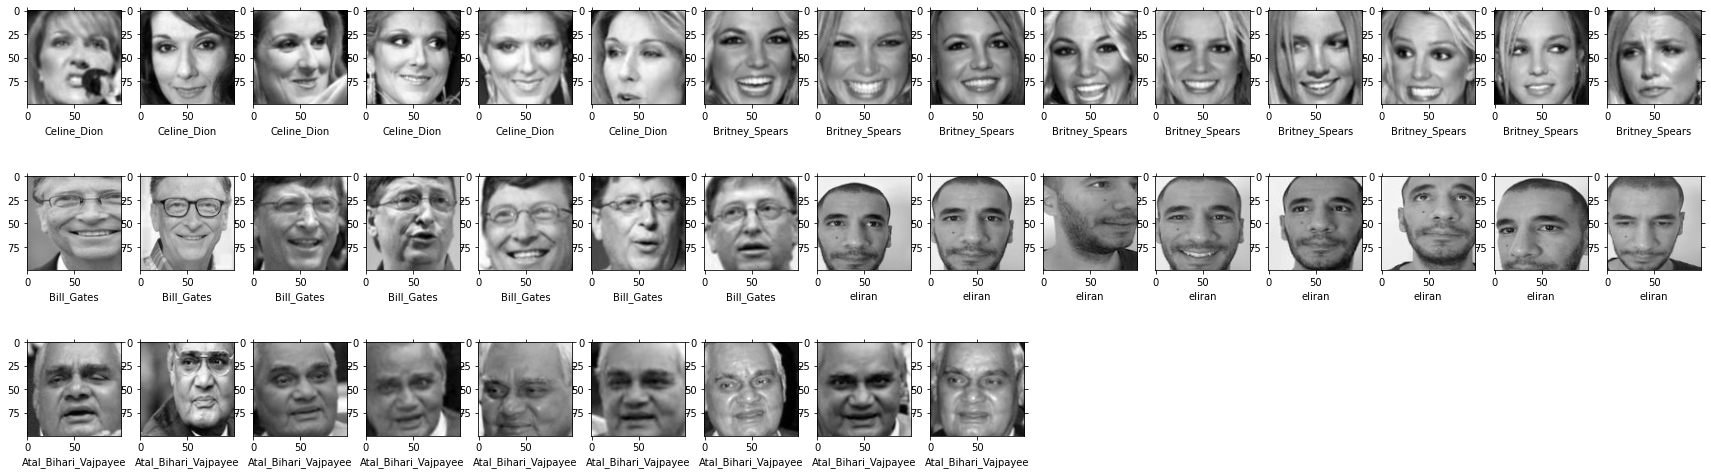

In [7]:
training_set_matrix = plot_set_and_get_matrix(training_set_images, training_set_labels)

# Loading and plotting the test set

In [8]:
test_set_labels, test_set_images, test_file_names = load_images_set(resources_path="resources/images/", files_to_ignore=training_file_names, leave_out=0)

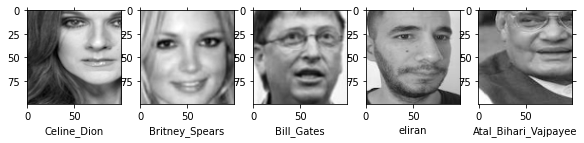

In [9]:
test_set_matrix = plot_set_and_get_matrix(test_set_images, test_set_labels)

# The Mean face

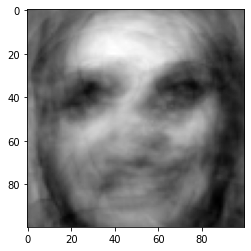

In [10]:
width, height = training_set_images[0].shape
meanface_vector =  training_set_matrix.mean(0).flatten()
plt.imshow(meanface_vector.reshape(height, width), cmap='gray')

# Normalized training matrix (training set, mean subtracted)

In [11]:
normalized_training_matrix = np.ndarray(shape=(len(training_set_labels), height*width))
for i in range(len(training_set_labels)):
    normalized_training_matrix[i] = np.subtract(training_set_matrix[i], meanface_vector)

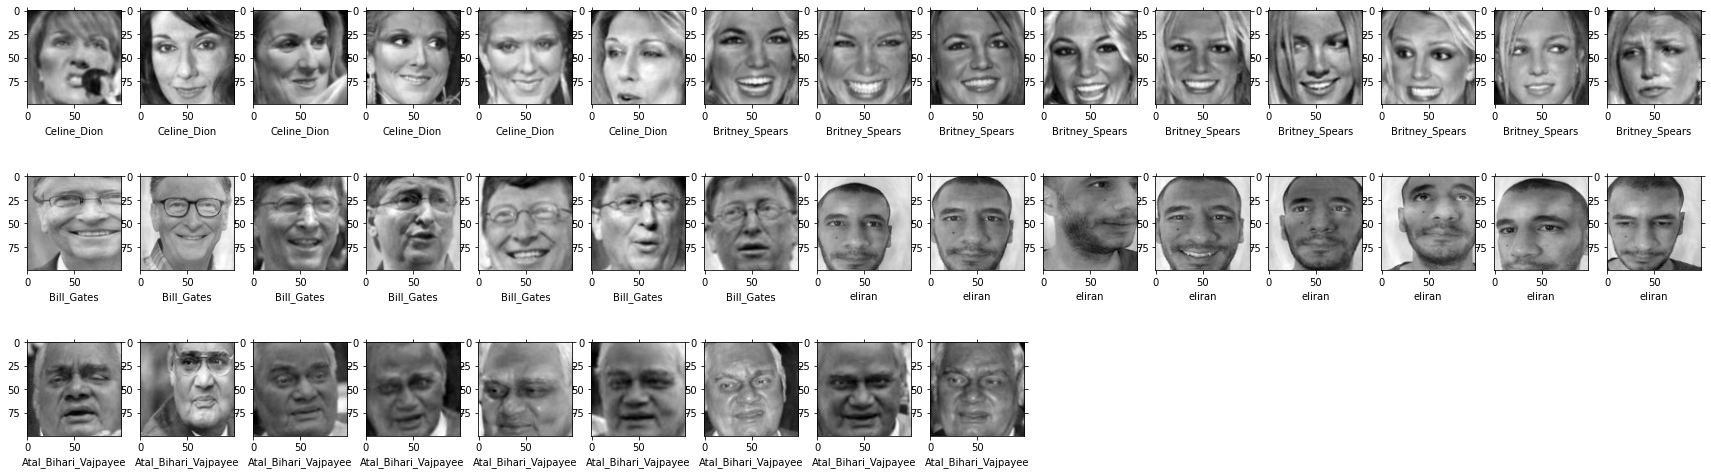

In [12]:
fig = plt.figure(figsize=(30, 30))
for i in range(len(training_set_labels)):
    eigenface = normalized_training_matrix[i].reshape(height, width)
    fig.add_subplot(10, 15, i+1).set_xlabel(training_set_labels[i])
    plt.imshow(eigenface, cmap='gray')
    plt.tick_params(labelleft='off', labelbottom='on', bottom='off',top='off',right='off',left='off', which='both')
plt.show()

# Calculating the Covariance matrix of the training set,
## extracting eigenvalues and eigenvectors using numpy linalg eig
## and ordering them by descending order of the eigenvalues

In [13]:
covariance_matrix = np.divide(np.cov(normalized_training_matrix), len(training_set_labels))
eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)
sorted_indexes = eigenvalues.argsort()[::-1] # sort the indexes of the eigenvalues in descending order, and get sorted indexes
eigenvalues = eigenvalues[sorted_indexes]
eigenvectors = eigenvectors[:, sorted_indexes]

# find and plot K significant eigen faces
## After getting the eigenvectors in  order we can get the K most significant easily

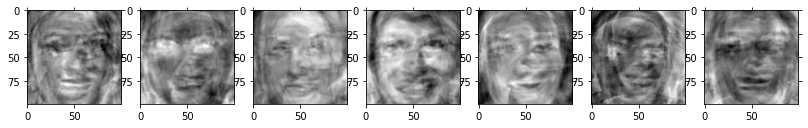

In [14]:
k_top_components_matrix = np.array(eigenvectors[:K]).transpose()
eiganspace = np.dot(training_set_matrix.transpose(), k_top_components_matrix).transpose()

fig = plt.figure(figsize=(30, 30))
for i in range(K):
    eigenface = eiganspace[i].reshape(height, width)
    fig.add_subplot(K, 15, i+1)
    plt.imshow(eigenface, cmap='gray')
    plt.tick_params(labelleft='off', labelbottom='on', bottom='off',top='off',right='off',left='off', which='both')
plt.show()

# Calculating Weights by calculating dot product of 
### eiganspace with each column vector of the normalized training set matrix

In [15]:
weights = np.array([np.dot(eiganspace, column_vector) for column_vector in normalized_training_matrix])

In [16]:
def classify(image_path=None, image=None, eigenspace=None, weights=None):
    if image_path is None and image is not None:
        subject = image
    elif image_path is not None and image is None:
        subject = load_image_as_grayscale(image_path)
    else:
        raise Exception("Please pass image_path OR image, not both!")
    subject_vector = np.array(subject, dtype=np.float64).flatten()
    normalized_subject_vector = np.subtract(subject_vector, meanface_vector)
    weights_for_subject = np.dot(eiganspace, normalized_subject_vector)
    diff = weights - weights_for_subject
    norms_of_diff = np.linalg.norm(diff, axis=1)
    minimal_diff_norm_index = np.argmin(norms_of_diff)
    print("norms_of_diff[minimal_diff_norm_index]: ", norms_of_diff[minimal_diff_norm_index])
    
    # TODO - Find a good threshold 
    threshold = 24256668
    fig = plt.figure(figsize=(30, 30))
    if norms_of_diff[minimal_diff_norm_index] < threshold:
        fig.add_subplot(10, 15, 1).set_xlabel(f"Matched successfully: {training_set_labels[minimal_diff_norm_index]}", color='g')

    else:
        fig.add_subplot(10, 15, 1).set_xlabel(f"Matched poorly: {training_set_labels[minimal_diff_norm_index]}", color='r')

    plt.imshow(training_set_images[minimal_diff_norm_index], cmap='gray')
    plt.tick_params(labelleft='off', labelbottom='on', bottom='off',top='off',right='off',left='off', which='both')
    plt.show()
        


# First we'll show that the classifier works perfectly on the training set
## But that's not a big deal

Actual File Name: resources/images/Celine_Dion/Celine_Dion_0008.jpg
norms_of_diff[minimal_diff_norm_index]:  0.0


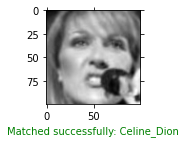

Actual File Name: resources/images/Celine_Dion/Celine_Dion_0001.jpg
norms_of_diff[minimal_diff_norm_index]:  0.0


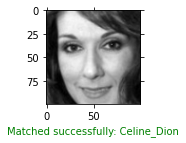

Actual File Name: resources/images/Celine_Dion/Celine_Dion_0002.jpg
norms_of_diff[minimal_diff_norm_index]:  0.0


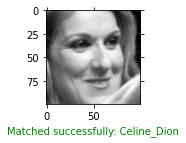

Actual File Name: resources/images/Celine_Dion/Celine_Dion_0006.jpg
norms_of_diff[minimal_diff_norm_index]:  0.0


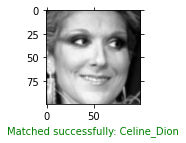

Actual File Name: resources/images/Celine_Dion/Celine_Dion_0007.jpg
norms_of_diff[minimal_diff_norm_index]:  0.0


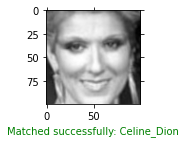

Actual File Name: resources/images/Celine_Dion/Celine_Dion_0005.jpg
norms_of_diff[minimal_diff_norm_index]:  0.0


Actual File Name: resources/images/Britney_Spears/Britney_Spears_0003.jpg
norms_of_diff[minimal_diff_norm_index]:  0.0


Actual File Name: resources/images/Britney_Spears/Britney_Spears_0002.jpg
norms_of_diff[minimal_diff_norm_index]:  0.0


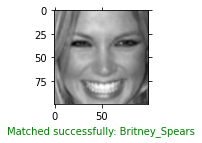

Actual File Name: resources/images/Britney_Spears/Britney_Spears_0014.jpg
norms_of_diff[minimal_diff_norm_index]:  0.0


Actual File Name: resources/images/Britney_Spears/Britney_Spears_0005.jpg
norms_of_diff[minimal_diff_norm_index]:  0.0


Actual File Name: resources/images/Britney_Spears/Britney_Spears_0010.jpg
norms_of_diff[minimal_diff_norm_index]:  0.0


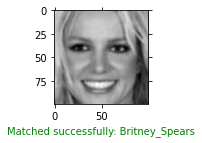

Actual File Name: resources/images/Britney_Spears/Britney_Spears_0006.jpg
norms_of_diff[minimal_diff_norm_index]:  0.0


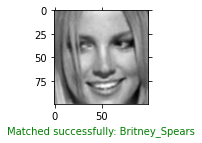

Actual File Name: resources/images/Britney_Spears/Britney_Spears_0012.jpg
norms_of_diff[minimal_diff_norm_index]:  0.0


Actual File Name: resources/images/Britney_Spears/Britney_Spears_0013.jpg
norms_of_diff[minimal_diff_norm_index]:  0.0


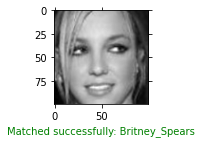

Actual File Name: resources/images/Britney_Spears/Britney_Spears_0007.jpg
norms_of_diff[minimal_diff_norm_index]:  0.0


Actual File Name: resources/images/Bill_Gates/Bill_Gates_8.jpg
norms_of_diff[minimal_diff_norm_index]:  0.0


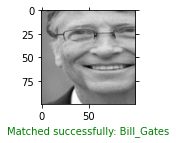

Actual File Name: resources/images/Bill_Gates/Bill_Gates_9.jpg
norms_of_diff[minimal_diff_norm_index]:  0.0


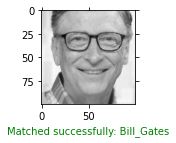

Actual File Name: resources/images/Bill_Gates/Bill_Gates_2.jpg
norms_of_diff[minimal_diff_norm_index]:  0.0


Actual File Name: resources/images/Bill_Gates/Bill_Gates_3.jpg
norms_of_diff[minimal_diff_norm_index]:  0.0


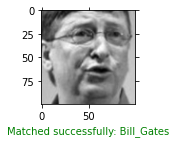

Actual File Name: resources/images/Bill_Gates/Bill_Gates_4.jpg
norms_of_diff[minimal_diff_norm_index]:  0.0


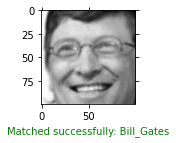

Actual File Name: resources/images/Bill_Gates/Bill_Gates_5.jpg
norms_of_diff[minimal_diff_norm_index]:  0.0


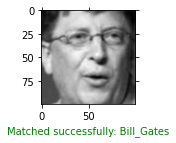

Actual File Name: resources/images/Bill_Gates/Bill_Gates_7.jpg
norms_of_diff[minimal_diff_norm_index]:  0.0


Actual File Name: resources/images/eliran/Eliran_9.jpg
norms_of_diff[minimal_diff_norm_index]:  0.0


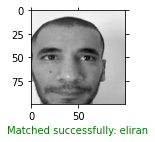

Actual File Name: resources/images/eliran/Eliran_8.jpg
norms_of_diff[minimal_diff_norm_index]:  0.0


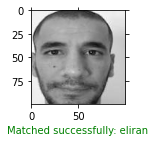

Actual File Name: resources/images/eliran/Eliran_10.jpg
norms_of_diff[minimal_diff_norm_index]:  0.0


Actual File Name: resources/images/eliran/Eliran_3.jpg
norms_of_diff[minimal_diff_norm_index]:  0.0


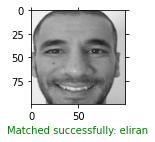

Actual File Name: resources/images/eliran/Eliran_2.jpg
norms_of_diff[minimal_diff_norm_index]:  0.0


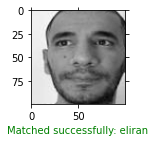

Actual File Name: resources/images/eliran/Eliran_1.jpg
norms_of_diff[minimal_diff_norm_index]:  0.0


Actual File Name: resources/images/eliran/Eliran_5.jpg
norms_of_diff[minimal_diff_norm_index]:  0.0


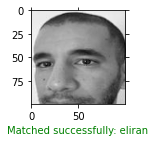

Actual File Name: resources/images/eliran/Eliran_6.jpg
norms_of_diff[minimal_diff_norm_index]:  0.0


Actual File Name: resources/images/Atal_Bihari_Vajpayee/Atal_Bihari_Vajpayee_8.jpg
norms_of_diff[minimal_diff_norm_index]:  0.0


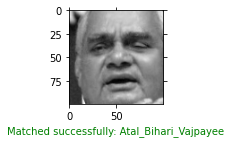

Actual File Name: resources/images/Atal_Bihari_Vajpayee/Atal_Bihari_Vajpayee_9.jpg
norms_of_diff[minimal_diff_norm_index]:  0.0


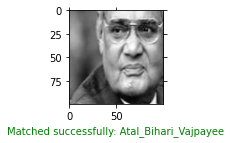

Actual File Name: resources/images/Atal_Bihari_Vajpayee/Atal_Bihari_Vajpayee_4.jpg
norms_of_diff[minimal_diff_norm_index]:  0.0


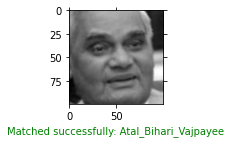

Actual File Name: resources/images/Atal_Bihari_Vajpayee/Atal_Bihari_Vajpayee_5.jpg
norms_of_diff[minimal_diff_norm_index]:  0.0


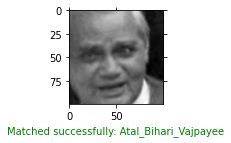

Actual File Name: resources/images/Atal_Bihari_Vajpayee/Atal_Bihari_Vajpayee_7.jpg
norms_of_diff[minimal_diff_norm_index]:  0.0


Actual File Name: resources/images/Atal_Bihari_Vajpayee/Atal_Bihari_Vajpayee_6.jpg
norms_of_diff[minimal_diff_norm_index]:  0.0


Actual File Name: resources/images/Atal_Bihari_Vajpayee/Atal_Bihari_Vajpayee_2.jpg
norms_of_diff[minimal_diff_norm_index]:  0.0


Actual File Name: resources/images/Atal_Bihari_Vajpayee/Atal_Bihari_Vajpayee_3.jpg
norms_of_diff[minimal_diff_norm_index]:  0.0


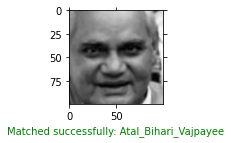

Actual File Name: resources/images/Atal_Bihari_Vajpayee/Atal_Bihari_Vajpayee_1.jpg
norms_of_diff[minimal_diff_norm_index]:  0.0


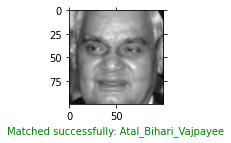

In [17]:
for i in range(len(training_file_names)):
    print(f"Actual File Name: {training_file_names[i]}")
    classify(None, training_set_images [i], eiganspace, weights)

# And here's a run on the test set
### As you can see the results are not great, adjustments to K and to the treshold should do the trick

Actual File Name: resources/images/Celine_Dion/Celine-Dion-Paul-Chiasson-Photoshoot-2007-celine-dion-23532533-1396-2000.jpg
norms_of_diff[minimal_diff_norm_index]:  10597129.722382788


Actual File Name: resources/images/Britney_Spears/Britney_Spears_0009.jpg
norms_of_diff[minimal_diff_norm_index]:  19664567.563996814


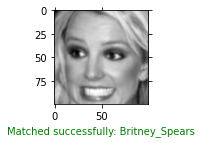

Actual File Name: resources/images/Bill_Gates/Bill_Gates_6.jpg
norms_of_diff[minimal_diff_norm_index]:  12819137.637371534


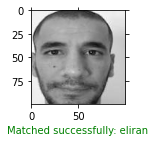

Actual File Name: resources/images/eliran/Eliran_7.jpg
norms_of_diff[minimal_diff_norm_index]:  8545901.669966284


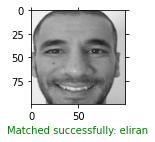

Actual File Name: resources/images/Atal_Bihari_Vajpayee/Atal_Bihari_Vajpayee_10.jpg
norms_of_diff[minimal_diff_norm_index]:  9221763.613119027


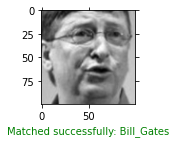

In [18]:
for i in range(len(test_file_names)):
    print(f"Actual File Name: {test_file_names[i]}")
    classify(None, test_set_images[i], eiganspace, weights)